### import statements:

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mirandahunter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers

2023-04-25 09:27:05.876262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from keras.layers import Embedding

In [5]:
import tensorflow as tf

### reading file and extracting pandas dataframe from it

In [6]:
path = "clean_IMDBdataset.csv"
df = pd.read_csv(path, sep=",")

### splitting dataset into training, testing, validation

In [83]:
#splitting clean IMDB dataset into training (80%), testing/validation(20%)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=30)
print("Train: " ,X_train.shape,Y_train.shape,"Test/Valid: ",(X_test.shape,Y_test.shape))

Train:  (40000,) (40000,) Test/Valid:  ((10000,), (10000,))


In [84]:
#splitting testing/validation into separate groups so testing is 10% and validation is 10%
X_test,X_valid,Y_test, Y_valid = train_test_split(X_test,Y_test, test_size=0.5, random_state=30)
print("Test: " ,X_test.shape,Y_test.shape,"Valid: ",(X_valid.shape,Y_valid.shape))

Test:  (5000,) (5000,) Valid:  ((5000,), (5000,))


### Turning strings into 0s and 1s

In [85]:
Y_test[Y_test == "negative"] = 0
Y_test[Y_test == "positive"] = 1

Y_valid[Y_valid == "negative"] = 0
Y_valid[Y_valid == "positive"] = 1

Y_train[Y_train == "negative"] = 0
Y_train[Y_train == "positive"] = 1

### Changing Y train and Y valid to float arrays

In [10]:
Y_train_array = np.asarray(Y_train).astype(np.float32)

In [11]:
Y_valid_array = np.asarray(Y_valid).astype(np.float32)

### Creating smaller train groups

In [12]:
small_X_train = X_train[:1000]
small_Y_train = Y_valid_array[:1000]

In [13]:
small_X_valid = X_valid[:200]
small_Y_valid = Y_valid_array[:200]

### tokenizing train and valid data

In [24]:
#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
max_words = 2000
max_len=500

#creating tokenizer by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient 
#for each token could be binary, based on word count, based on tf-idf...
tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
tokenizer.fit_on_texts(X_train)

#Transforms each text in texts to a sequence of integers.
sequences = tokenizer.texts_to_sequences(X_train)

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape 
#(num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest 
#sequence in the list.
X_train_sequences = pad_sequences(sequences, maxlen=max_len)

In [25]:
# the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
max_words = 2000
max_len=500

#creating tokenizer by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient 
#for each token could be binary, based on word count, based on tf-idf...
tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
tokenizer.fit_on_texts(X_valid)

#Transforms each text in texts to a sequence of integers.
sequences = tokenizer.texts_to_sequences(X_valid)

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape 
#(num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest 
#sequence in the list.
X_valid_sequences = pad_sequences(sequences, maxlen=max_len)

### Tokenizing small training arrays

In [16]:
max_words = 1000
max_len=500

tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

tokenizer.fit_on_texts(small_X_train)

sequences = tokenizer.texts_to_sequences(small_X_train)

small_X_train_sequences = pad_sequences(sequences, maxlen=max_len)

In [17]:
max_words = 1000
max_len=500

tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

tokenizer.fit_on_texts(small_X_valid)

sequences = tokenizer.texts_to_sequences(small_X_valid)

small_X_valid_sequences = pad_sequences(sequences, maxlen=max_len)

### First LSTM Model, ultimately realized using a simpler model was better

In [32]:
#first LSTM model, using better (?) binary RNN model below
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20)) #The embedding layer
model1.add(layers.LSTM(15,dropout=0)) #Our LSTM layer
model1.add(layers.Dense(1,activation='sigmoid'))


In [33]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)

In [35]:
history = model1.fit(X_train_sequences, Y_train_array, epochs=1,validation_data=(X_valid_sequences, Y_valid_array),verbose = 1,callbacks=[checkpoint1])

1250/1250 [==============================] - 247s 195ms/step - loss: 0.4208 - accuracy: 0.8128 - val_loss: 0.9405 - val_accuracy: 0.5092


### Bidirectional Model, way too complex

In [37]:
#A Sequential model is appropriate for a plain stack of layers where each layer 
#has exactly one input tensor and one output tensor.
model2 = Sequential()

In [38]:
#adding embedding layer with input dimension of 2000 (max_words) and output layer of 40 (?), all inputs are 500
model2.add(layers.Embedding(max_words, 40, input_length=max_len))

In [39]:
#LSTM: dimensionality of output is 20, dropout = Fraction of the units to drop for the linear transformation of the inputs
#runs bidirectionally
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.5)))

In [40]:
#dimensionality 1 for output, Activation function to use, could also try other functions?
model2.add(layers.Dense(1,activation='sigmoid'))

In [41]:
#String (name of optimizer) or optimizer instance
#Loss function. May be a string (name of loss function), or a tf.keras.losses.Loss instance.
#List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), 
    #function or a tf.keras.metrics.Metric instance
model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#Callback to save the Keras model or model weights at some frequency.
#first thing: filepath
#monitor: The metric name to monitor. Typically the metrics are set by the Model.compile method.
#verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
#if save_best_only=True, it only saves when the model is considered the "best" and the latest best model 
    #according to the quantity monitored will not be overwritten
#mode: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on 
    #either the maximization or the minimization of the monitored quantity
#save_freq:'epoch' or integer. When using 'epoch', the callback saves the model after each epoch. When using integer, 
    #the callback saves the model at end of this many batches.
#save_weight_only:if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)

In [43]:
history = model2.fit(X_train_sequences, Y_train_array, epochs=1,validation_data=(X_valid_sequences, Y_valid_array),verbose=1,callbacks=[checkpoint2])

1250/1250 [==============================] - 418s 332ms/step - loss: 0.4219 - accuracy: 0.8098 - val_loss: 0.9559 - val_accuracy: 0.5118


### First Simple RNN Model, using L1 regularizer at 0.01 and 0.3 dropout. Best val_acc at epoch 1 at .56

In [12]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 500)) #The embedding layer
model3.add(layers.Dense(200,activation='sigmoid'))
model3.add(layers.Dense(100,activation='sigmoid'))
model3.add(layers.Dense(20,activation='sigmoid'))
model3.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer='l1'))
model3.add(layers.Dense(1,activation='sigmoid'))

2023-04-21 14:49:53.088736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
checkpoint3 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)

In [20]:
history3 = model3.fit(X_train_sequences, Y_train_array, epochs=10,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint3])

Epoch 1/10
625/625 [==============================] - 328s 522ms/step - loss: 0.8751 - accuracy: 0.6097 - val_loss: 0.8049 - val_accuracy: 0.5646
Epoch 2/10
625/625 [==============================] - 416s 666ms/step - loss: 0.5980 - accuracy: 0.7312 - val_loss: 1.0649 - val_accuracy: 0.5022
Epoch 3/10
625/625 [==============================] - 364s 582ms/step - loss: 0.5240 - accuracy: 0.7775 - val_loss: 0.9120 - val_accuracy: 0.5370
Epoch 4/10
625/625 [==============================] - 336s 538ms/step - loss: 0.4819 - accuracy: 0.8028 - val_loss: 0.8603 - val_accuracy: 0.5184
Epoch 5/10
625/625 [==============================] - 346s 553ms/step - loss: 0.4760 - accuracy: 0.8027 - val_loss: 0.8541 - val_accuracy: 0.5142
Epoch 6/10
625/625 [==============================] - 337s 539ms/step - loss: 0.4448 - accuracy: 0.8232 - val_loss: 1.0358 - val_accuracy: 0.4980
Epoch 7/10
625/625 [==============================] - 332s 532ms/step - loss: 0.4319 - accuracy: 0.8278 - val_loss: 0.9659 -

### Simple RNN using L2 regularizer and 0.3 dropout, best val_acc at epoch 2 at 0.54

In [21]:
model4 = Sequential()
model4.add(layers.Embedding(max_words, 500)) #The embedding layer
model4.add(layers.Dense(200,activation='sigmoid'))
model4.add(layers.Dense(100,activation='sigmoid'))
model4.add(layers.Dense(20,activation='sigmoid'))
model4.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer='l2'))
model4.add(layers.Dense(1,activation='sigmoid'))

In [22]:
model4.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
checkpoint4 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)

In [24]:
history4 = model4.fit(X_train_sequences, Y_train_array, epochs=10,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint4])

Epoch 1/10
625/625 [==============================] - 359s 572ms/step - loss: 0.7022 - accuracy: 0.6066 - val_loss: 0.8813 - val_accuracy: 0.5054
Epoch 2/10
625/625 [==============================] - 351s 561ms/step - loss: 0.5665 - accuracy: 0.7312 - val_loss: 0.7811 - val_accuracy: 0.5468
Epoch 3/10
625/625 [==============================] - 360s 575ms/step - loss: 0.4907 - accuracy: 0.7809 - val_loss: 0.9043 - val_accuracy: 0.5064
Epoch 4/10
625/625 [==============================] - 354s 566ms/step - loss: 0.4541 - accuracy: 0.8022 - val_loss: 0.9246 - val_accuracy: 0.5032
Epoch 5/10
625/625 [==============================] - 369s 590ms/step - loss: 0.4313 - accuracy: 0.8169 - val_loss: 1.0194 - val_accuracy: 0.4998
Epoch 6/10
625/625 [==============================] - 346s 553ms/step - loss: 0.4108 - accuracy: 0.8271 - val_loss: 1.0297 - val_accuracy: 0.5016
Epoch 7/10
625/625 [==============================] - 338s 540ms/step - loss: 0.3993 - accuracy: 0.8334 - val_loss: 1.0618 -

### Simple RNN model using l1_l2 regularizer and 0.3 dropout, best val_acc at epoch 2 at 0.53

In [26]:
model5 = Sequential()
model5.add(layers.Embedding(max_words, 500)) #The embedding layer
model5.add(layers.Dense(200,activation='sigmoid'))
model5.add(layers.Dense(100,activation='sigmoid'))
model5.add(layers.Dense(20,activation='sigmoid'))
model5.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer='l1_l2'))
model5.add(layers.Dense(1,activation='sigmoid'))
model5.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint5 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history5 = model5.fit(X_train_sequences, Y_train_array, epochs=10,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint5])

Epoch 1/10
625/625 [==============================] - 499s 795ms/step - loss: 0.9070 - accuracy: 0.5765 - val_loss: 0.7687 - val_accuracy: 0.5260
Epoch 2/10
625/625 [==============================] - 347s 556ms/step - loss: 0.6097 - accuracy: 0.7113 - val_loss: 0.7827 - val_accuracy: 0.5304
Epoch 3/10
625/625 [==============================] - 415s 664ms/step - loss: 0.5100 - accuracy: 0.7794 - val_loss: 0.7975 - val_accuracy: 0.5200
Epoch 4/10
625/625 [==============================] - 353s 565ms/step - loss: 0.4721 - accuracy: 0.8019 - val_loss: 0.8763 - val_accuracy: 0.5100
Epoch 5/10
625/625 [==============================] - 365s 584ms/step - loss: 0.4488 - accuracy: 0.8141 - val_loss: 0.9053 - val_accuracy: 0.5074
Epoch 6/10
625/625 [==============================] - 357s 571ms/step - loss: 0.4368 - accuracy: 0.8204 - val_loss: 0.8730 - val_accuracy: 0.4898
Epoch 7/10
625/625 [==============================] - 356s 570ms/step - loss: 0.4236 - accuracy: 0.8271 - val_loss: 0.8661 -

### Simple RNN model using orthogonal regularizer, best val_acc at Epoch 2 at 0.52

In [27]:
regularizer = tf.keras.regularizers.OrthogonalRegularizer(factor=0.01)

model6 = Sequential()
model6.add(layers.Embedding(max_words, 500)) #The embedding layer
model6.add(layers.Dense(200,activation='sigmoid'))
model6.add(layers.Dense(100,activation='sigmoid'))
model6.add(layers.Dense(20,activation='sigmoid'))
model6.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model6.add(layers.Dense(1,activation='sigmoid'))
model6.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint6 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history6 = model6.fit(X_train_sequences, Y_train_array, epochs=10,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint6])

Epoch 1/10
625/625 [==============================] - 727s 1s/step - loss: 0.6481 - accuracy: 0.6086 - val_loss: 0.8148 - val_accuracy: 0.5040
Epoch 2/10
625/625 [==============================] - 355s 568ms/step - loss: 0.5659 - accuracy: 0.7199 - val_loss: 0.8297 - val_accuracy: 0.5248
Epoch 3/10
625/625 [==============================] - 351s 562ms/step - loss: 0.5110 - accuracy: 0.7626 - val_loss: 0.8578 - val_accuracy: 0.5038
Epoch 4/10
625/625 [==============================] - 440s 705ms/step - loss: 0.4869 - accuracy: 0.7782 - val_loss: 0.8794 - val_accuracy: 0.5166
Epoch 5/10
625/625 [==============================] - 368s 589ms/step - loss: 0.4777 - accuracy: 0.7820 - val_loss: 0.9215 - val_accuracy: 0.5056
Epoch 6/10
625/625 [==============================] - 349s 558ms/step - loss: 0.4801 - accuracy: 0.7816 - val_loss: 1.0778 - val_accuracy: 0.4894
Epoch 7/10
625/625 [==============================] - 349s 558ms/step - loss: 0.4545 - accuracy: 0.8012 - val_loss: 0.8755 - va

### Simple RNN model using L1 regularizer at 0.03, best val_acc at epoch 1 at 0.55

In [38]:
regularizer = tf.keras.regularizers.L1(l1=0.03)
model7 = Sequential()
model7.add(layers.Embedding(max_words, 500)) #The embedding layer
model7.add(layers.Dense(200,activation='sigmoid'))
model7.add(layers.Dense(100,activation='sigmoid'))
model7.add(layers.Dense(20,activation='sigmoid'))
model7.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model7.add(layers.Dense(1,activation='sigmoid'))
model7.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint7 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history5 = model7.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=32,verbose = 1,callbacks=[checkpoint7])

Epoch 1/5
1250/1250 [==============================] - 454s 360ms/step - loss: 0.9122 - accuracy: 0.6034 - val_loss: 0.7953 - val_accuracy: 0.5516
Epoch 2/5
1250/1250 [==============================] - 478s 383ms/step - loss: 0.5571 - accuracy: 0.7563 - val_loss: 1.0360 - val_accuracy: 0.5122
Epoch 3/5
1250/1250 [==============================] - 461s 369ms/step - loss: 0.5025 - accuracy: 0.7934 - val_loss: 0.9773 - val_accuracy: 0.5404
Epoch 4/5
1250/1250 [==============================] - 444s 355ms/step - loss: 0.4785 - accuracy: 0.8077 - val_loss: 0.9791 - val_accuracy: 0.5176
Epoch 5/5
1250/1250 [==============================] - 443s 355ms/step - loss: 0.4657 - accuracy: 0.8177 - val_loss: 0.9713 - val_accuracy: 0.5080


### Simple RNN model using L1 regularizer at 0.05, best val_acc at epoch 2 at 0.56

In [39]:
regularizer = tf.keras.regularizers.L1(l1=0.05)
model8 = Sequential()
model8.add(layers.Embedding(max_words, 500)) #The embedding layer
model8.add(layers.Dense(200,activation='sigmoid'))
model8.add(layers.Dense(100,activation='sigmoid'))
model8.add(layers.Dense(20,activation='sigmoid'))
model8.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model8.add(layers.Dense(1,activation='sigmoid'))
model8.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint8 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history8 = model8.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint8])

Epoch 1/5
625/625 [==============================] - 343s 546ms/step - loss: 1.4615 - accuracy: 0.6026 - val_loss: 0.7862 - val_accuracy: 0.5470
Epoch 2/5
625/625 [==============================] - 343s 549ms/step - loss: 0.6004 - accuracy: 0.7334 - val_loss: 0.8822 - val_accuracy: 0.5616
Epoch 3/5
625/625 [==============================] - 342s 548ms/step - loss: 0.5372 - accuracy: 0.7729 - val_loss: 0.9590 - val_accuracy: 0.5200
Epoch 4/5
625/625 [==============================] - 396s 634ms/step - loss: 0.5094 - accuracy: 0.7915 - val_loss: 0.7964 - val_accuracy: 0.5154
Epoch 5/5
625/625 [==============================] - 372s 595ms/step - loss: 0.4853 - accuracy: 0.8051 - val_loss: 0.8701 - val_accuracy: 0.5116


### Simple RNN model using L1 regularizer at 0.1, best val_acc at epoch 2 at 0.55

In [40]:
regularizer = tf.keras.regularizers.L1(l1=0.1)
model9 = Sequential()
model9.add(layers.Embedding(max_words, 500)) #The embedding layer
model9.add(layers.Dense(200,activation='sigmoid'))
model9.add(layers.Dense(100,activation='sigmoid'))
model9.add(layers.Dense(20,activation='sigmoid'))
model9.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model9.add(layers.Dense(1,activation='sigmoid'))
model9.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint9 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history9 = model9.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint9])

Epoch 1/5
625/625 [==============================] - 352s 561ms/step - loss: 2.2327 - accuracy: 0.6217 - val_loss: 0.8126 - val_accuracy: 0.5432
Epoch 2/5
625/625 [==============================] - 354s 567ms/step - loss: 0.6024 - accuracy: 0.7436 - val_loss: 0.8416 - val_accuracy: 0.5550
Epoch 3/5
625/625 [==============================] - 353s 565ms/step - loss: 0.5645 - accuracy: 0.7683 - val_loss: 0.8410 - val_accuracy: 0.5444
Epoch 4/5
625/625 [==============================] - 356s 570ms/step - loss: 0.5292 - accuracy: 0.7874 - val_loss: 1.0071 - val_accuracy: 0.5282
Epoch 5/5
625/625 [==============================] - 351s 562ms/step - loss: 0.5130 - accuracy: 0.7951 - val_loss: 0.9088 - val_accuracy: 0.5214


### Simple RNN model using L1 regularizer at 0.1 and batch size = 128, best val_acc at epoch 3 at 0.55

In [41]:
regularizer = tf.keras.regularizers.L1(l1=0.1)
model10 = Sequential()
model10.add(layers.Embedding(max_words, 500)) #The embedding layer
model10.add(layers.Dense(200,activation='sigmoid'))
model10.add(layers.Dense(100,activation='sigmoid'))
model10.add(layers.Dense(20,activation='sigmoid'))
model10.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model10.add(layers.Dense(1,activation='sigmoid'))
model10.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint10 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history10 = model10.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=128,verbose = 1,callbacks=[checkpoint10])

Epoch 1/5
313/313 [==============================] - 329s 1s/step - loss: 3.9241 - accuracy: 0.6007 - val_loss: 1.5318 - val_accuracy: 0.5266
Epoch 2/5
313/313 [==============================] - 339s 1s/step - loss: 0.8746 - accuracy: 0.7303 - val_loss: 0.9828 - val_accuracy: 0.5328
Epoch 3/5
313/313 [==============================] - 332s 1s/step - loss: 0.6485 - accuracy: 0.7539 - val_loss: 0.9088 - val_accuracy: 0.5538
Epoch 4/5
313/313 [==============================] - 342s 1s/step - loss: 0.5969 - accuracy: 0.7670 - val_loss: 0.8166 - val_accuracy: 0.5366
Epoch 5/5
313/313 [==============================] - 341s 1s/step - loss: 0.5716 - accuracy: 0.7746 - val_loss: 0.8316 - val_accuracy: 0.5362


### Simple RNN model using L1 regularizer at 0.08, best val_acc at epoch 5 at 0.54

In [47]:
regularizer = tf.keras.regularizers.L1(l1=0.08)
model10 = Sequential()
model10.add(layers.Embedding(max_words, 500)) #The embedding layer
model10.add(layers.Dense(200,activation='sigmoid'))
model10.add(layers.Dense(100,activation='sigmoid'))
model10.add(layers.Dense(20,activation='sigmoid'))
model10.add(layers.SimpleRNN(20,dropout=0.2))
model10.add(layers.Dense(1,activation='sigmoid', kernel_regularizer=regularizer))
model10.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint10 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history10 = model10.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint10])

Epoch 1/5
625/625 [==============================] - 363s 579ms/step - loss: 0.7872 - accuracy: 0.6143 - val_loss: 0.7361 - val_accuracy: 0.5252
Epoch 2/5
625/625 [==============================] - 375s 600ms/step - loss: 0.6747 - accuracy: 0.6752 - val_loss: 0.7388 - val_accuracy: 0.5142
Epoch 3/5
625/625 [==============================] - 368s 588ms/step - loss: 0.6607 - accuracy: 0.7066 - val_loss: 0.7811 - val_accuracy: 0.5064
Epoch 4/5
625/625 [==============================] - 1333s 2s/step - loss: 0.6615 - accuracy: 0.7007 - val_loss: 0.7720 - val_accuracy: 0.5210
Epoch 5/5
625/625 [==============================] - 1440s 2s/step - loss: 0.6396 - accuracy: 0.7398 - val_loss: 0.7910 - val_accuracy: 0.5394


### Simple RNN model using L1 regularizer at 0.02 and dropout = 0.7, best val_acc at epoch 2 at 0.55

In [20]:
regularizer = tf.keras.regularizers.L1(l1=0.02)
model11 = Sequential()
model11.add(layers.Embedding(max_words, 500)) #The embedding layer
model11.add(layers.Dense(200,activation='sigmoid'))
model11.add(layers.Dense(100,activation='sigmoid'))
model11.add(layers.Dense(20,activation='sigmoid'))
model11.add(layers.SimpleRNN(20,dropout=0.7, kernel_regularizer=regularizer))
model11.add(layers.Dense(1,activation='sigmoid'))
model11.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint11 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history11 = model11.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint11])

Epoch 1/5
625/625 [==============================] - 362s 577ms/step - loss: 1.0698 - accuracy: 0.5977 - val_loss: 0.8809 - val_accuracy: 0.5268
Epoch 2/5
625/625 [==============================] - 508s 814ms/step - loss: 0.5923 - accuracy: 0.7446 - val_loss: 0.8594 - val_accuracy: 0.5460
Epoch 3/5
625/625 [==============================] - 415s 664ms/step - loss: 0.5406 - accuracy: 0.7722 - val_loss: 1.0543 - val_accuracy: 0.5122
Epoch 4/5
625/625 [==============================] - 409s 654ms/step - loss: 0.5153 - accuracy: 0.7861 - val_loss: 0.8139 - val_accuracy: 0.5032
Epoch 5/5
625/625 [==============================] - 394s 631ms/step - loss: 0.4982 - accuracy: 0.7916 - val_loss: 0.8747 - val_accuracy: 0.4954


### Simple RNN model using L1 regularizer at 0.015 and mse loss, best val_acc at epoch 1 at 0.55

In [24]:
regularizer = tf.keras.regularizers.L1(l1=0.015)
model12 = Sequential()
model12.add(layers.Embedding(max_words, 500)) #The embedding layer
model12.add(layers.Dense(200,activation='sigmoid'))
model12.add(layers.Dense(100,activation='sigmoid'))
model12.add(layers.Dense(20,activation='sigmoid'))
model12.add(layers.SimpleRNN(20,dropout=0.4,kernel_regularizer=regularizer))
model12.add(layers.Dense(1,activation='sigmoid'))
model12.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
checkpoint12 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history12 = model12.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint12])

Epoch 1/5
625/625 [==============================] - 386s 614ms/step - loss: 0.5176 - accuracy: 0.6414 - val_loss: 0.3337 - val_accuracy: 0.5500
Epoch 2/5
625/625 [==============================] - 367s 586ms/step - loss: 0.1978 - accuracy: 0.7644 - val_loss: 0.3136 - val_accuracy: 0.5344
Epoch 3/5
625/625 [==============================] - 408s 653ms/step - loss: 0.1727 - accuracy: 0.7897 - val_loss: 0.3736 - val_accuracy: 0.5206
Epoch 4/5
625/625 [==============================] - 366s 585ms/step - loss: 0.1600 - accuracy: 0.8033 - val_loss: 0.3318 - val_accuracy: 0.5132
Epoch 5/5
625/625 [==============================] - 395s 633ms/step - loss: 0.1551 - accuracy: 0.8093 - val_loss: 0.3641 - val_accuracy: 0.5070


### Simple RNN model using L1 regularizer at 0.01 and relu activation, best val_acc at epoch 3 at 0.51

In [27]:
regularizer = tf.keras.regularizers.L1(l1=0.01)
model13 = Sequential()
model13.add(layers.Embedding(max_words, 500)) #The embedding layer
model13.add(layers.Dense(200,activation='relu'))
model13.add(layers.Dense(100,activation='sigmoid'))
model13.add(layers.Dense(20,activation='relu'))
model13.add(layers.SimpleRNN(20,dropout=0.4,kernel_regularizer=regularizer))
model13.add(layers.Dense(1,activation='sigmoid'))
model13.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint13 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history13 = model13.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint13])

Epoch 1/5
625/625 [==============================] - 321s 511ms/step - loss: 0.8127 - accuracy: 0.6512 - val_loss: 0.9169 - val_accuracy: 0.5026
Epoch 2/5
625/625 [==============================] - 345s 552ms/step - loss: 0.5103 - accuracy: 0.7869 - val_loss: 1.0100 - val_accuracy: 0.5012
Epoch 3/5
625/625 [==============================] - 350s 560ms/step - loss: 0.4483 - accuracy: 0.8173 - val_loss: 1.1620 - val_accuracy: 0.5126
Epoch 4/5
625/625 [==============================] - 644s 1s/step - loss: 0.4551 - accuracy: 0.8213 - val_loss: 0.8708 - val_accuracy: 0.5012
Epoch 5/5
625/625 [==============================] - 368s 589ms/step - loss: 0.4167 - accuracy: 0.8343 - val_loss: 1.0726 - val_accuracy: 0.4858


### Adding LeakyReLU layer and adam optimizer, best val_acc at Epoch 2 at .54

In [54]:
regularizer = tf.keras.regularizers.L1(l1=0.01)
model14 = Sequential()
model14.add(layers.Embedding(max_words, 500)) #The embedding layer
model14.add(layers.Dense(200,activation='sigmoid'))
model14.add(layers.Dense(100,activation='sigmoid'))
model14.add(layers.LeakyReLU(alpha=0.3))
model14.add(layers.Dense(20,activation='sigmoid'))
model14.add(layers.SimpleRNN(20,dropout=0.4,kernel_regularizer=regularizer))
model14.add(layers.Dense(1,activation='sigmoid'))
model14.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint14 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history14 = model14.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=128,verbose = 1,callbacks=[checkpoint14])

Epoch 1/5
313/313 [==============================] - 337s 1s/step - loss: 1.1298 - accuracy: 0.5720 - val_loss: 0.9376 - val_accuracy: 0.4990
Epoch 2/5
313/313 [==============================] - 326s 1s/step - loss: 0.8091 - accuracy: 0.6356 - val_loss: 0.8854 - val_accuracy: 0.5414
Epoch 3/5
313/313 [==============================] - 331s 1s/step - loss: 0.6635 - accuracy: 0.7225 - val_loss: 0.9088 - val_accuracy: 0.5442
Epoch 4/5
313/313 [==============================] - 316s 1s/step - loss: 0.6000 - accuracy: 0.7527 - val_loss: 0.7782 - val_accuracy: 0.5208
Epoch 5/5
313/313 [==============================] - 329s 1s/step - loss: 0.7965 - accuracy: 0.6092 - val_loss: 0.8074 - val_accuracy: 0.5190


### Adding multiple SimpleRNN layers, ran very slowly and not working well so I ended early

In [61]:
regularizer = tf.keras.regularizers.L1(l1=0.01)
model14 = Sequential()
model14.add(layers.Embedding(max_words, 500)) #The embedding layer
model14.add(layers.Dense(200,activation='sigmoid'))
model14.add(layers.SimpleRNN(100,return_sequences=True,dropout=0.1,kernel_regularizer=regularizer))
model14.add(layers.Dense(100,activation='sigmoid'))
model14.add(layers.Dense(20,activation='sigmoid'))
model14.add(layers.SimpleRNN(20,dropout=0.2,kernel_regularizer=regularizer))
model14.add(layers.Dense(1,activation='sigmoid'))
model14.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint14 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history14 = model14.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint14])

Epoch 1/5
625/625 [==============================] - 607s 968ms/step - loss: 2.0062 - accuracy: 0.5026 - val_loss: 0.7219 - val_accuracy: 0.5020
Epoch 2/5
625/625 [==============================] - 600s 959ms/step - loss: 0.7188 - accuracy: 0.4975 - val_loss: 0.7179 - val_accuracy: 0.5020
Epoch 3/5
 21/625 [>.............................] - ETA: 9:39 - loss: 0.7184 - accuracy: 0.5089

KeyboardInterrupt: 

### L1 regularizer at 0.05 and dropout at 0.4, best val_acc at epoch 1 at 0.56

In [63]:
regularizer = tf.keras.regularizers.L1(l1=0.05)
model8 = Sequential()
model8.add(layers.Embedding(max_words, 500)) #The embedding layer
model8.add(layers.Dense(200,activation='sigmoid'))
model8.add(layers.Dense(100,activation='sigmoid'))
model8.add(layers.Dense(20,activation='sigmoid'))
model8.add(layers.SimpleRNN(20,dropout=0.4, kernel_regularizer=regularizer))
model8.add(layers.Dense(1,activation='sigmoid'))
model8.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint8 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history8 = model8.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint8])

Epoch 1/5
625/625 [==============================] - 348s 554ms/step - loss: 1.4482 - accuracy: 0.5803 - val_loss: 0.7546 - val_accuracy: 0.5598
Epoch 2/5
625/625 [==============================] - 356s 569ms/step - loss: 0.5893 - accuracy: 0.7351 - val_loss: 0.8690 - val_accuracy: 0.5374
Epoch 3/5
625/625 [==============================] - 354s 566ms/step - loss: 0.5257 - accuracy: 0.7780 - val_loss: 0.8494 - val_accuracy: 0.5510
Epoch 4/5
625/625 [==============================] - 356s 570ms/step - loss: 0.5035 - accuracy: 0.7926 - val_loss: 0.9131 - val_accuracy: 0.5152
Epoch 5/5
625/625 [==============================] - 357s 570ms/step - loss: 0.4751 - accuracy: 0.8049 - val_loss: 0.8478 - val_accuracy: 0.4962


### Running the best model, L1 Regularizer at 0.05 and dropout at 0.3, for 30 epochs! Did not see any increase in val_acc over time and actually performed worse after 2 epochs

In [64]:
regularizer = tf.keras.regularizers.L1(l1=0.05)
model15 = Sequential()
model15.add(layers.Embedding(max_words, 500)) #The embedding layer
model15.add(layers.Dense(200,activation='sigmoid'))
model15.add(layers.Dense(100,activation='sigmoid'))
model15.add(layers.Dense(20,activation='sigmoid'))
model15.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model15.add(layers.Dense(1,activation='sigmoid'))
model15.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint15 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
history15 = model15.fit(X_train_sequences, Y_train_array, epochs=30,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint15])

Epoch 1/30
625/625 [==============================] - 327s 521ms/step - loss: 1.4432 - accuracy: 0.6268 - val_loss: 0.8666 - val_accuracy: 0.5202
Epoch 2/30
625/625 [==============================] - 328s 524ms/step - loss: 0.5794 - accuracy: 0.7538 - val_loss: 0.8241 - val_accuracy: 0.5506
Epoch 3/30
625/625 [==============================] - 345s 552ms/step - loss: 0.5393 - accuracy: 0.7771 - val_loss: 0.8896 - val_accuracy: 0.5368
Epoch 4/30
625/625 [==============================] - 330s 527ms/step - loss: 0.5069 - accuracy: 0.7925 - val_loss: 0.8583 - val_accuracy: 0.5250
Epoch 5/30
625/625 [==============================] - 331s 530ms/step - loss: 0.4796 - accuracy: 0.8091 - val_loss: 0.9827 - val_accuracy: 0.5160
Epoch 6/30
625/625 [==============================] - 327s 523ms/step - loss: 0.4714 - accuracy: 0.8113 - val_loss: 1.0099 - val_accuracy: 0.5118
Epoch 7/30
625/625 [==============================] - 360s 575ms/step - loss: 0.4561 - accuracy: 0.8207 - val_loss: 0.8552 -

### Running the best model for 2 epochs, using EarlyStopping to make sure it stops quickly before the overfitting becomes very bad, however, first epoch is still significantly better than the second.

In [30]:
regularizer = tf.keras.regularizers.L1(l1=0.05)
model8 = Sequential()
model8.add(layers.Embedding(max_words, 500)) #The embedding layer
model8.add(layers.Dense(200,activation='sigmoid'))
model8.add(layers.Dense(100,activation='sigmoid'))
model8.add(layers.Dense(20,activation='sigmoid'))
model8.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model8.add(layers.Dense(1,activation='sigmoid'))
model8.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint8 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
earlystop8 = EarlyStopping(monitor='val_loss', verbose=0, min_delta=0.01, baseline=0.55)
history8 = model8.fit(X_train_sequences, Y_train_array, epochs=5,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint8,earlystop8])

Epoch 1/5
625/625 [==============================] - 376s 598ms/step - loss: 1.5378 - accuracy: 0.6072 - val_loss: 0.7892 - val_accuracy: 0.5594
Epoch 2/5
625/625 [==============================] - 362s 578ms/step - loss: 0.5947 - accuracy: 0.7380 - val_loss: 0.8632 - val_accuracy: 0.5166


### Ran the model for just 1 epoch to get the best possible val_acc and to reduce overfitting!!

In [33]:
regularizer = tf.keras.regularizers.L1(l1=0.05)
model16 = Sequential()
model16.add(layers.Embedding(max_words, 500)) #The embedding layer
model16.add(layers.Dense(200,activation='sigmoid'))
model16.add(layers.Dense(100,activation='sigmoid'))
model16.add(layers.Dense(20,activation='sigmoid'))
model16.add(layers.SimpleRNN(20,dropout=0.3, kernel_regularizer=regularizer))
model16.add(layers.Dense(1,activation='sigmoid'))
model16.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint16 = ModelCheckpoint("best_model1.hdf5", monitor='val_loss', verbose=0,save_best_only=True, mode='auto', save_freq="epoch",save_weights_only=False)
earlystop16 = EarlyStopping(monitor='val_loss', verbose=0, min_delta=0.01, baseline=0.55)
history16 = model16.fit(X_train_sequences, Y_train_array, epochs=1,validation_data=(X_valid_sequences, Y_valid_array),batch_size=64,verbose = 1,callbacks=[checkpoint16,earlystop16])

625/625 [==============================] - 388s 617ms/step - loss: 1.4344 - accuracy: 0.6038 - val_loss: 0.7515 - val_accuracy: 0.5638


### Time to predict on the test data, need to turn the test X data into sequences and the test Y data into an array

In [34]:
Y_test_array = np.asarray(Y_test).astype(np.float32)

In [35]:
#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
max_words = 2000
max_len=500

#creating tokenizer by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient 
#for each token could be binary, based on word count, based on tf-idf...
tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
tokenizer.fit_on_texts(X_test)

#Transforms each text in texts to a sequence of integers.
sequences = tokenizer.texts_to_sequences(X_test)

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape 
#(num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest 
#sequence in the list.
X_test_sequences = pad_sequences(sequences, maxlen=max_len)

### Split test data into batches

In [46]:
i = 64
X_batches = []
Y_batches = []
while(i < X_test_sequences.shape[0]):
    this_X_batch = X_test_sequences[i-64:i]
    this_Y_batch = Y_test_array[i-64:i]
    X_batches.append(this_X_batch)
    Y_batches.append(this_Y_batch)
    i+=64

### Time to test!!

In [53]:
results = []
i = 0
while( i < len(X_batches) ):
    result = model16.test_on_batch(x=X_batches[i], y=Y_batches[i], reset_metrics=True)
    results.append(result)
    i+=1

In [55]:
print(model16.metrics_names)
print(results)

['loss', 'accuracy']
[[0.6869397759437561, 0.640625], [0.7087468504905701, 0.625], [0.6941721439361572, 0.59375], [0.8217992186546326, 0.5], [0.7123985886573792, 0.609375], [0.7053833603858948, 0.609375], [0.7636483311653137, 0.59375], [0.6975687146186829, 0.625], [0.7361975312232971, 0.5625], [0.8457841277122498, 0.515625], [0.813751757144928, 0.484375], [0.7139145731925964, 0.59375], [0.661302387714386, 0.65625], [0.7028974890708923, 0.671875], [0.6632857918739319, 0.671875], [0.7416196465492249, 0.546875], [0.7071908712387085, 0.609375], [0.7043229937553406, 0.625], [0.7460721731185913, 0.609375], [0.7357705235481262, 0.578125], [0.7043769359588623, 0.640625], [0.6501519083976746, 0.640625], [0.7382586598396301, 0.546875], [0.7737110257148743, 0.53125], [0.7508490085601807, 0.53125], [0.7076207995414734, 0.578125], [0.7813892960548401, 0.5], [0.7510342001914978, 0.578125], [0.7360690236091614, 0.53125], [0.6640822887420654, 0.671875], [0.6724541187286377, 0.6875], [0.655189335346221

In [56]:
import matplotlib.pyplot as plt

In [59]:
batch_nums = []
accuracy_results = []

for i in range(len(results)):
    batch_nums.append(i)
    accuracy_results.append(results[i][1])

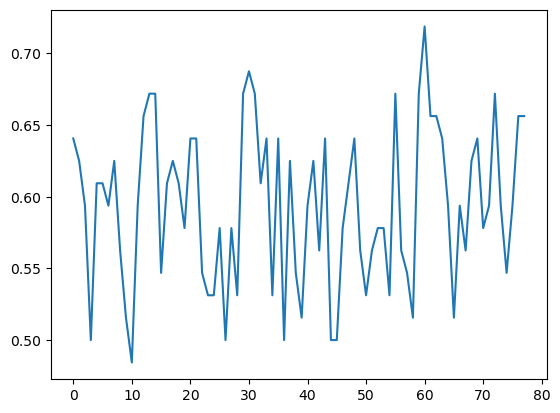

In [61]:
plt.plot(batch_nums, accuracy_results)

In [62]:
np.mean(accuracy_results)

0.5935496794871795

In [64]:
np.max(accuracy_results)

0.71875

In [65]:
np.min(accuracy_results)

0.484375

### Now time to test on the Rotten Tomatoes Dataset

### First, load test data

In [105]:
rt_path = "RottenTomatoes/DataSet/train.tsv"
rt_df = pd.read_csv(path, sep="\t")

In [107]:
# remove punctuation
rt_df['Phrase'] = rt_df['Phrase'].str.replace(r'[^\w\s]+', '')
# remove numbers
rt_df['Phrase'] = rt_df['Phrase'].str.replace(r'\d+', '')
# make it all lower case
rt_df['Phrase'] = rt_df['Phrase'].str.lower()
# remove non-asci characters
rt_df.Phrase.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

rt_df['Sentiment']=rt_df['Sentiment'].astype(int) #convert the star_rating column to int

rt_df= rt_df[rt_df['Sentiment']!=2]

/var/folders/gd/1k6gf7yn51b89wq72200y5dr0000gn/T/ipykernel_41764/569102518.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  rt_df['Phrase'] = rt_df['Phrase'].str.replace(r'[^\w\s]+', '')
/var/folders/gd/1k6gf7yn51b89wq72200y5dr0000gn/T/ipykernel_41764/569102518.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  rt_df['Phrase'] = rt_df['Phrase'].str.replace(r'\d+', '')


In [108]:
# Data Preprocessing
rt_X_train,rt_X_test,rt_Y_train, rt_Y_test = train_test_split(rt_df['Phrase'], rt_df['Sentiment'], test_size=0.2, random_state=30)
print("Train: " ,rt_X_train.shape,rt_Y_train.shape,"Test/Valid: ",(rt_X_test.shape,rt_Y_test.shape))

Train:  (61182,) (61182,) Test/Valid:  ((15296,), (15296,))


In [109]:
#splitting testing/validation into separate groups so testing is 10% and validation is 10%
rt_X_test,rt_X_valid,rt_Y_test, rt_Y_valid = train_test_split(rt_X_test,rt_Y_test, test_size=0.5, random_state=30)
print("Test: " ,rt_X_test.shape,rt_Y_test.shape,"Valid: ",(rt_X_valid.shape,rt_Y_valid.shape))

Test:  (7648,) (7648,) Valid:  ((7648,), (7648,))


### Turn the 1s to 0.25, 3s to 0.75, 4s to 1

In [110]:
rt_Y_test[rt_Y_test == 1] = .25
rt_Y_test[rt_Y_test == 3] = .75
rt_Y_test[rt_Y_test == 4] = 1

### Preprocess data

In [111]:
#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
max_words = 2000
max_len=500

#creating tokenizer by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient 
#for each token could be binary, based on word count, based on tf-idf...
rt_tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
rt_tokenizer.fit_on_texts(rt_X_test)

#Transforms each text in texts to a sequence of integers.
rt_sequences = rt_tokenizer.texts_to_sequences(rt_X_test)

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape 
#(num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest 
#sequence in the list.
rt_X_test_sequences = pad_sequences(rt_sequences, maxlen=max_len)

In [112]:
rt_Y_test_array = np.asarray(rt_Y_test).astype(np.float32)

### Split test data into batches

In [113]:
i = 64
rt_X_batches = []
rt_Y_batches = []
while(i < rt_X_test_sequences.shape[0]):
    this_X_batch = rt_X_test_sequences[i-64:i]
    this_Y_batch = rt_Y_test_array[i-64:i]
    rt_X_batches.append(this_X_batch)
    rt_Y_batches.append(this_Y_batch)
    i+=64

### Time to test Rotten Tomatoes Subjectivity!

In [114]:
rt_results = []
i = 0
while( i < len(rt_X_batches) ):
    result = model16.test_on_batch(x=rt_X_batches[i], y=rt_Y_batches[i], reset_metrics=True)
    rt_results.append(result)
    i+=1

In [115]:
rt_batch_nums = []
rt_accuracy_results = []

for i in range(len(rt_results)):
    rt_batch_nums.append(i)
    rt_accuracy_results.append(rt_results[i][1])

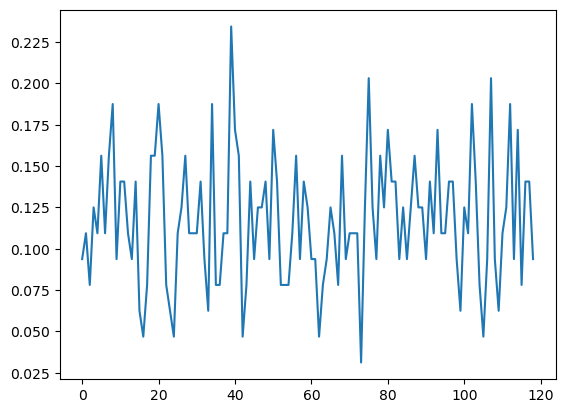

In [116]:
plt.plot(rt_batch_nums, rt_accuracy_results)

In [117]:
np.mean(rt_accuracy_results)

0.1171218487394958

In [118]:
np.max(rt_accuracy_results)

0.234375

In [119]:
np.min(rt_accuracy_results)

0.03125

### Clearly, that didn't work well. Now going to try converting Rotten Tomatoes to Polarity

In [120]:
rt_Y_test[rt_Y_test == .25] = 0
rt_Y_test[rt_Y_test == .75] = 1

### Now test again

In [121]:
#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
max_words = 2000
max_len=500

#creating tokenizer by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient 
#for each token could be binary, based on word count, based on tf-idf...
rt_tokenizer = Tokenizer(num_words=max_words,lower=True,split=' ')

#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
rt_tokenizer.fit_on_texts(rt_X_test)

#Transforms each text in texts to a sequence of integers.
rt_sequences = rt_tokenizer.texts_to_sequences(rt_X_test)

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape 
#(num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest 
#sequence in the list.
rt_X_test_sequences = pad_sequences(rt_sequences, maxlen=max_len)

In [122]:
rt_Y_test_array = np.asarray(rt_Y_test).astype(np.float32)

In [123]:
i = 64
rt_X_batches = []
rt_Y_batches = []
while(i < rt_X_test_sequences.shape[0]):
    this_X_batch = rt_X_test_sequences[i-64:i]
    this_Y_batch = rt_Y_test_array[i-64:i]
    rt_X_batches.append(this_X_batch)
    rt_Y_batches.append(this_Y_batch)
    i+=64

In [124]:
rt_results = []
i = 0
while( i < len(rt_X_batches) ):
    result = model16.test_on_batch(x=rt_X_batches[i], y=rt_Y_batches[i], reset_metrics=True)
    rt_results.append(result)
    i+=1

In [125]:
rt_batch_nums = []
rt_accuracy_results = []

for i in range(len(rt_results)):
    rt_batch_nums.append(i)
    rt_accuracy_results.append(rt_results[i][1])

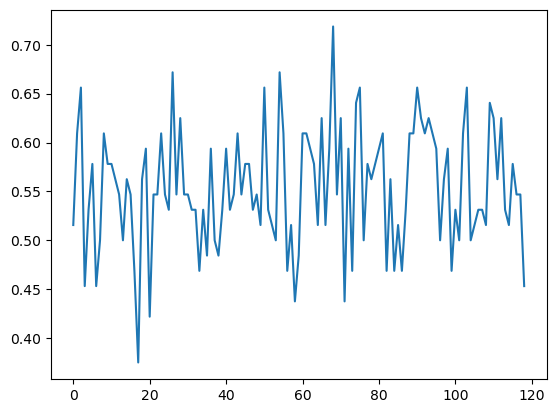

In [126]:
plt.plot(rt_batch_nums, rt_accuracy_results)

In [127]:
np.mean(rt_accuracy_results)

0.553702731092437

In [128]:
np.max(rt_accuracy_results)

0.71875

In [129]:
np.min(rt_accuracy_results)

0.375

### Much better! This probably means the model only guesses 0s and 1s so subjectivity doesn't work unless you convert to polarity. With more time it would be better to retrain the model so it guesses a decimal percentage (and rounds to the closest whole number for polarity)